# 0. Read data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.plot import *

In [2]:
mrsa_mcad = anndata.read_h5ad("../../02.clustering/02.5K/MRSA.TSNE.UMAP.mcad")

In [3]:
ctrl_mcad = anndata.read_h5ad("../../../07.Ctrl/HIVpre_Flupre_Ctrl.All.TSNE.HM.h5ad")

In [4]:
mrsa_meta = pd.read_csv("../../02.clustering/02.5K/cell2cluster.csv")

In [5]:
ctrl_meta = pd.read_csv("../../../07.Ctrl/ControlCell2cluster.csv")

/tmp/ipykernel_1610507/624261551.py:1: DtypeWarning: Columns (2,42,43,44,45,50,51,52,53,55,56,58,60,62,64,65,66,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  ctrl_meta = pd.read_csv("../../../07.Ctrl/ControlCell2cluster.csv")


# 1. Filtering and merge

In [6]:
ctrl_mcad = ctrl_mcad[ctrl_meta['cell'].to_list()]
mrsa_mcad = mrsa_mcad[mrsa_meta['cell'].to_list()]

In [8]:
mcad = anndata.concat([mrsa_mcad, ctrl_mcad])

In [9]:
id2cohort = dict(zip(mrsa_mcad.obs.index, mrsa_mcad.obs['Cohort']))

In [10]:
mcad.obs['Cohort'] = [id2cohort[x] if x in id2cohort else 'Ctrl' for x in mcad.obs.index]

# 2. Clustering

In [12]:
pc_cutoff = 0.1

resolution = 1

In [13]:
lsi(mcad, algorithm='arpack', obsm='X_pca', n_components=50)
n_components = significant_pc_test(mcad, p_cutoff=pc_cutoff, update=False)
mcad.obsm['5kCG_pca'] = mcad.obsm['X_pca'].copy()

45 components passed P cutoff of 0.1.


In [14]:
mcad.obsm['X_pca'] = mcad.obsm['5kCG_pca'][:, :32]
sc.pp.neighbors(mcad)
sc.tl.leiden(mcad, resolution=resolution)

## T-SNE

In [15]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return

In [16]:
tsne(mcad,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
dump_embedding(mcad, 'tsne')

In [17]:
mcad.obsm['5kCG_tsne'] = mcad.obsm['X_tsne'].copy()
mcad.obs['all_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['all_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['all_leiden'] = mcad.obs['leiden']

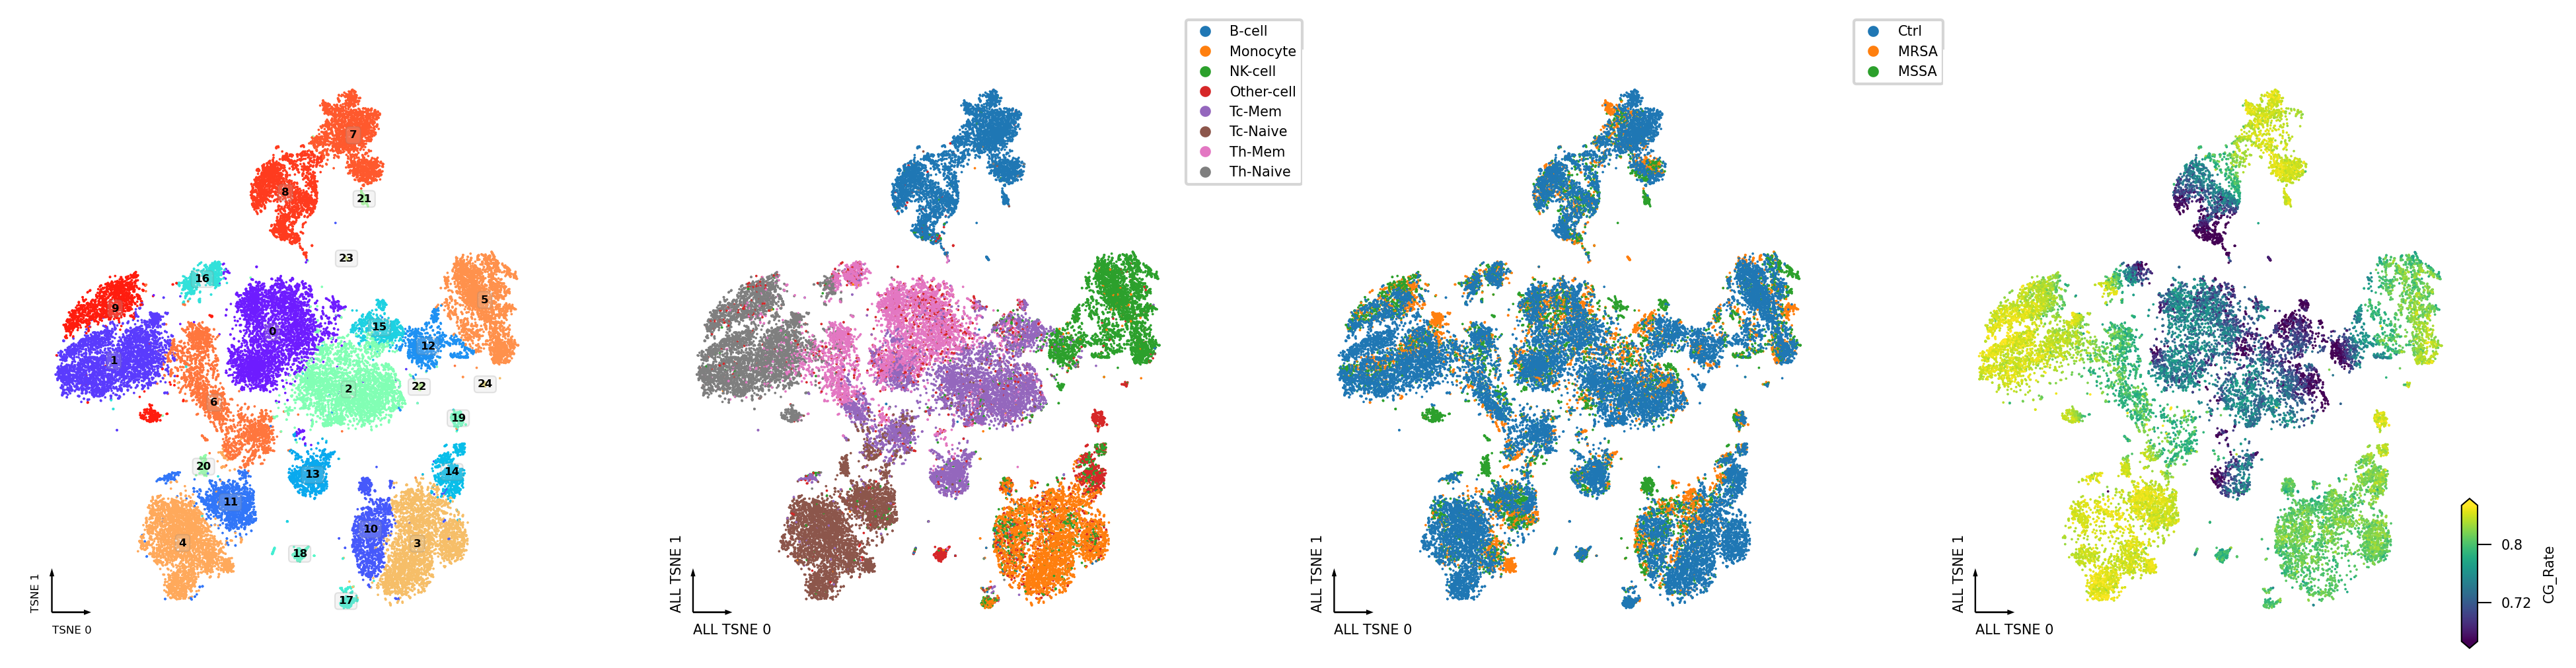

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='tsne', hue='leiden', show_legend=False, 
#                         legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                            text_anno="leiden")
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='all_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='all_tsne', hue='Cohort', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='all_tsne', hue='CG_Rate', labelsize=5)


In [ ]:
leiden2celltype = {
                  12: 'NK-cell1',
                  4: 'B-Naive',
                  5: 'B-Mem',
                  2: 'NK-cell2'}

In [ ]:
mcad.obs['annotation'] = mcad.obs.apply(lambda row: leiden2celltype[int(row['leiden'])] if int(row['leiden']) in leiden2celltype else row['cell_type'], axis=1)

In [ ]:
mcad.write_h5ad('MRSA.Ctrl.TSNE.Annotation.mcad')

In [ ]:
mcad.obs.to_csv("cell2cluster.csv")

In [2]:
metadata = pd.read_csv("cell2cluster.csv")

/tmp/ipykernel_1611799/1990708883.py:1: DtypeWarning: Columns (1,2,42,43,44,45,50,51,52,53,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("cell2cluster.csv")


In [9]:
sample_meta = pd.read_csv("/gale/netapp/DoD/wenliang/projects/02.MRSA/00.data/metadata2.tsv", sep="\t")

In [11]:
sample_meta['Plate ID'] = [f'MRSA_{x}' for x in sample_meta['Plate ID']]
id2donor = dict(zip(sample_meta['Plate ID'], sample_meta['donorID']))

In [14]:
metadata['DonorID'] = [id2donor[x] if x in id2donor else x for x in metadata['sampleID']]

In [16]:
metadata

cell                  uid index_name  \
0       MRSA_29-MRSA_30-A1-AD002   MRSA_29-MRSA_30-A1      ad002   
1      MRSA_29-MRSA_30-A10-AD006  MRSA_29-MRSA_30-A10      ad006   
2      MRSA_29-MRSA_30-A10-AD008  MRSA_29-MRSA_30-A10      ad008   
3      MRSA_29-MRSA_30-A10-AD012  MRSA_29-MRSA_30-A10      ad012   
4      MRSA_29-MRSA_30-A11-AD002  MRSA_29-MRSA_30-A11      ad002   
...                          ...                  ...        ...   
36034          Flu_9_1-6-M14-O12                  NaN        NaN   
36035          Flu_9_1-6-M14-O23                  NaN        NaN   
36036          Flu_9_1-6-M14-O24                  NaN        NaN   
36037          Flu_9_1-6-M14-P12                  NaN        NaN   
36038          Flu_9_1-6-M14-P24                  NaN        NaN   

       MultiplexReadsTotal  IndexReadsTotal  IndexReadsRatio  IndexBpTotal  \
0               28661408.0        2022612.0         7.056918   290223475.0   
1               22463808.0        4700038.0        20.922713   656741228.0   
2               22463808.0        3278372.0        14.594017   451661928.0   
3               22463808.0        3780908.0        16.831109   543183045.0   
4               25717164.0        6066854.0        23.590681   878759679.0   
...                    ...              ...              ...           ...   
36034                  NaN              NaN              NaN           NaN   
36035                  NaN              NaN              NaN           NaN   
36036                  NaN              NaN              NaN           NaN   
36037                  NaN              NaN              NaN           NaN   
36038                  NaN              NaN              NaN           NaN   

       IndexTrimedBpTotal  IndexTrimedReadsTotal  ReadsQualTrimBpTotal  ...  \
0             248309176.0              1960515.0              627596.0  ...   
1             557376077.0              4411951.0             1509306.0  ...   
2             381754500.0              3029193.0             1043403.0  ...   
3             464999525.0              3675486.0             1137473.0  ...   
4             753861834.0              5944004.0             1859933.0  ...   
...                   ...                    ...                   ...  ...   
36034                 NaN                    NaN                   NaN  ...   
36035                 NaN                    NaN                   NaN  ...   
36036                 NaN                    NaN                   NaN  ...   
36037                 NaN                    NaN                   NaN  ...   
36038                 NaN                    NaN                   NaN  ...   

          tsne_0     tsne_1  Cohort  all_tsne_0  all_tsne_1  all_leiden  \
0      30.789147 -46.895788    MSSA   30.789147  -46.895788           3   
1      46.939232 -25.930779    MSSA   46.939232  -25.930779          14   
2       2.562133 -46.192126    MRSA    2.562133  -46.192126          18   
3      49.269649 -10.785071    MRSA   49.269649  -10.785071          19   
4       0.557628 -46.285815    MSSA    0.557628  -46.285815          18   
...          ...        ...     ...         ...         ...         ...   
36034 -38.070439 -43.878407    Ctrl  -38.070439  -43.878407           4   
36035 -37.142799 -42.103286    Ctrl  -37.142799  -42.103286           4   
36036 -19.789411 -18.663100    Ctrl  -19.789411  -18.663100           6   
36037 -32.326769 -40.072866    Ctrl  -32.326769  -40.072866           4   
36038 -32.565385 -47.402085    Ctrl  -32.565385  -47.402085           4   

       annotation  mCG_level  mCH_level  DonorID  
0      Other-cell   0.801950   0.006518  SA07399  
1      Other-cell   0.834147   0.009092  SA07399  
2      Other-cell   0.783910   0.005615  SA07531  
3      Other-cell   0.852307   0.008068  SA07531  
4      Other-cell   0.810763   0.005967  SA07399  
...           ...        ...        ...      ...  
36034    Tc-Naive   0.829508   0.009501    Flu_9  
36035    Tc-Naiv

In [18]:
metadata['mCG_level'] = metadata['mCGFrac'].fillna(0) + metadata['CG_Rate'].fillna(0)
metadata['mCH_level'] = metadata['mCHFrac'].fillna(0) + metadata['CH_Rate'].fillna(0)

In [15]:
metadata.to_csv('cell2cluster.csv', index=False)

In [6]:
import matplotlib
matplotlib.rc("pdf", fonttype=42)

In [3]:
metadata=metadata[metadata['cell_type']!="Other-cell"]

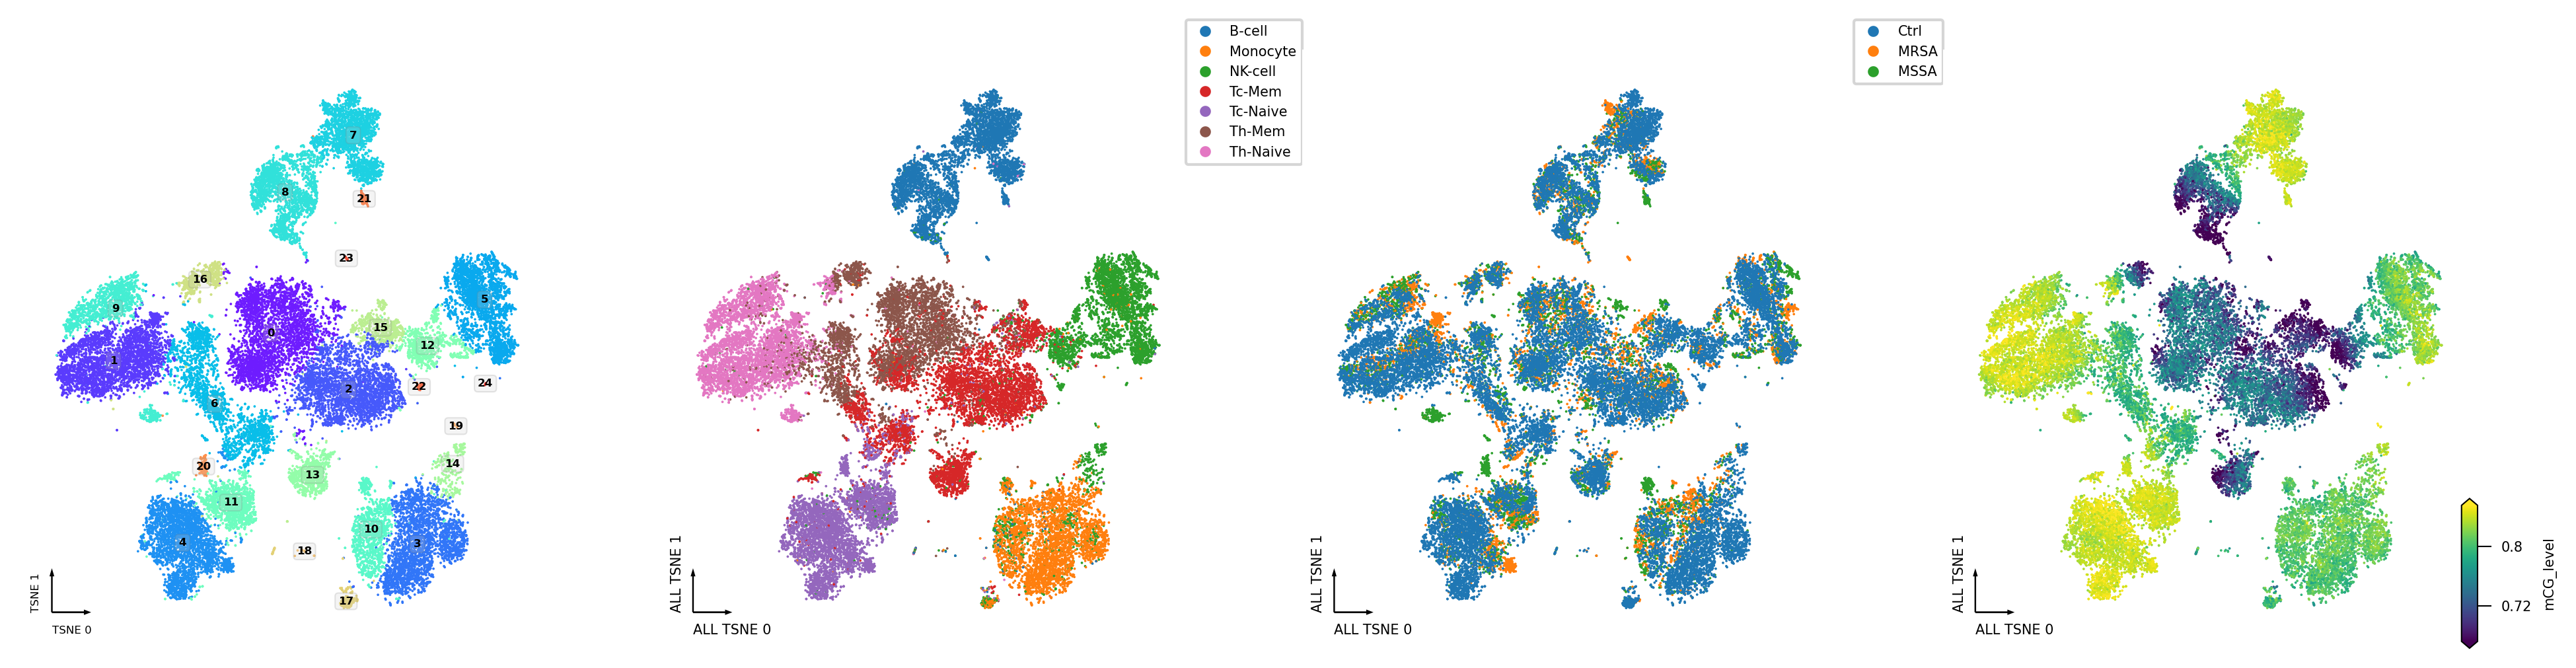

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=metadata, ax=axes[0], coord_base='tsne', hue='leiden', show_legend=False, 
#                         legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                            text_anno="leiden")
_ = categorical_scatter(data=metadata, ax=axes[1], coord_base='all_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=metadata, ax=axes[2], coord_base='all_tsne', hue='Cohort', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=metadata, ax=axes[3], coord_base='all_tsne', hue='mCG_level', labelsize=5)
plt.savefig("All_cluster.pdf")

In [5]:
from collections import defaultdict, Counter

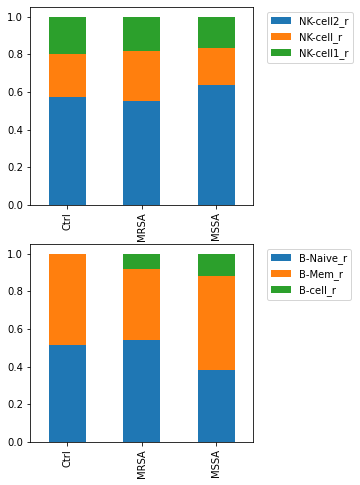

In [6]:
fig, axes = plt.subplots(2,1, figsize=(4,8))
count_list = list()
for i, celltype in enumerate(['NK-cell', 'B-cell']):
    cell_df = metadata[metadata['cell_type'] == celltype]
    count_dict = cell_df[['Cohort', 'annotation']].value_counts().to_dict()
    
    cell_counter = defaultdict(Counter)
    for (cond, cell) in count_dict:
        if count_dict[(cond, cell)] < 50:
            continue
        cell_counter[cond][cell] = count_dict[(cond, cell)]
        cell_counter[cond]['total'] += count_dict[(cond, cell)]
    cell_counter_df = pd.DataFrame.from_dict(cell_counter, orient='index')
    count_list.append(cell_counter_df)
    for cell in cell_counter_df.columns:
        if cell == 'total':
            continue
        cell_counter_df[f'{cell}_r'] = cell_counter_df.apply(lambda row: row[cell] / row['total'], axis=1)
    cell_counter_df[[x for x in cell_counter_df.columns if x.endswith("_r")]].sort_index().plot.bar(stacked=True, ax=axes[i])
    axes[i].legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('MRSA_B-NK_ratio.pdf')

In [8]:
data_df = pd.concat(count_list, axis=1)

In [10]:
from scipy.stats import chi2_contingency

In [11]:
chi2_contingency(data_df.loc[['Ctrl','MSSA','MRSA'], ['NK-cell2', 'NK-cell1', 'NK-cell']])

(19.7235986893247,
 0.0005662089612717574,
 4,
 array([[1672.10598179,  539.34893801,  655.54508019],
        [ 562.22886866,  181.35067187,  220.42045947],
        [ 456.66514954,  147.30039012,  179.03446034]]))

In [13]:
chi2_contingency(data_df.loc[['Ctrl','MSSA','MRSA'], ['B-Mem', 'B-Naive']])

(41.577786005302514,
 9.364799510542936e-10,
 2,
 array([[1347.15154968, 1413.84845032],
        [ 423.5159526 ,  444.4840474 ],
        [ 370.33249772,  388.66750228]]))